# SIames model evaluateion

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm import tqdm
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
from collections import defaultdict
import pandas as pd
import gc
import json
import matplotlib.pyplot as plt
from siamese_dataset2 import SiameseDataset


In [94]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")


## INIT THE MODEL

In [95]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.embedding = nn.Sequential(
            nn.Conv2d(3, 64, 10),  # Input is 100x100x3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, padding=1),  # padding is added to match 'same' padding in Keras
            nn.Conv2d(64, 128, 7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, padding=1),  # padding is added to match 'same' padding in Keras
            nn.Conv2d(128, 128, 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # padding is added to match 'same' padding in Keras
            nn.Conv2d(128, 256, 4),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(256*6*6, 4096),
            nn.Sigmoid()
        )
        self.classifier = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.embedding(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        l1_distance = torch.abs(output1 - output2)
        output = self.classifier(l1_distance)
        return output

model= SiameseNetwork()
# print(model)
model.to(device)
_=model.eval()

### Load Weights

In [96]:
model_path='/Users/aljazjustin/Siht/Praksa/Ear-based-recognition/SIames_model/Color-all_data5/best_model_acc.pth'

checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
# Remove 'module.' prefix
new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint['model_state_dict'].items()}
# Load the weights
model.load_state_dict(new_state_dict)
model.to(device)

SiameseNetwork(
  (embedding): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=9216, out_features=4096, bias=True)
    (13): Sigmoid()
  )
  (classifier): Linear(in_features=4096, out_features=1, bias=True)
)

### Prepear test dataset

In [97]:


transform = transforms.Compose([
            transforms.Resize((100, 100)),  # Resize images 
            # transforms.Grayscale(num_output_channels=3),  # Convert images to grayscale
            transforms.Lambda(lambda image: image.convert('RGB')),
            transforms.ToTensor(),  # Convert images to PyTorch tensors
        ])

test_files="/Users/aljazjustin/Siht/Praksa/NEW/final_data/test"

dataset_test = SiameseDataset(test_files, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


In [98]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()
predictions = []
labels = []

def evaluate_model(model, test_loader, threshold=0.5):
    for batch in test_loader:
        image1, image2, label = batch
        image1 = image1.to(device)
        image2 = image2.to(device)
        output = model(image1, image2)
        
        # Convert model output to label
        predicted_labels = (output > threshold).float()
        predictions.extend(predicted_labels.tolist())
        labels.extend(label.tolist())

    # Calculate precision and recall
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return precision, recall, accuracy, f1

precision, recall, accuracy, f1 = evaluate_model(model, test_loader)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


Precision: 0.8105263157894737
Recall: 0.8339350180505415
Accuracy: 0.8203592814371258
F1 Score: 0.8220640569395017


### Find the best threshold for the model

In [99]:
# find the best threshold for the model 
thresholds = {}
for i in range(34,84, 2):
    i=i/100
    precision, recall, accuracy, f1 = [], [], [], []
    
    for _ in range(10):
        precision_, recall_, accuracy_, f1_ = evaluate_model(model, test_loader, threshold=i)
        precision.append(precision_)
        recall.append(recall_)
        accuracy.append(accuracy_)
        f1.append(f1_)
    print(f'Threshold: {i},Accuracy: {np.mean(accuracy)}')    
    thresholds[i] = {'precision': np.mean(precision), 'recall': np.mean(recall), 'accuracy': np.mean(accuracy), 'f1': np.mean(f1)}

print(thresholds)
    


Threshold: 0.34,Accuracy: 0.8165623946911372
Threshold: 0.36,Accuracy: 0.8134558252766064
Threshold: 0.38,Accuracy: 0.8130911445100057
Threshold: 0.4,Accuracy: 0.8122924263727056
Threshold: 0.42,Accuracy: 0.8122615815436545
Threshold: 0.44,Accuracy: 0.812378350747349
Threshold: 0.46,Accuracy: 0.8126260887362886
Threshold: 0.48,Accuracy: 0.8124231008453353
Threshold: 0.5,Accuracy: 0.8124820897976809
Threshold: 0.52,Accuracy: 0.8126257391239872
Threshold: 0.54,Accuracy: 0.8127864705553163
Threshold: 0.56,Accuracy: 0.8128651658238425
Threshold: 0.58,Accuracy: 0.8129865226105185
Threshold: 0.6,Accuracy: 0.8129802190395827
Threshold: 0.62,Accuracy: 0.8129585770114091
Threshold: 0.64,Accuracy: 0.8129606501842763
Threshold: 0.66,Accuracy: 0.8129708458020801
Threshold: 0.68,Accuracy: 0.8129948903329163
Threshold: 0.7,Accuracy: 0.8129556628451367
Threshold: 0.72,Accuracy: 0.8129245081405004
Threshold: 0.74,Accuracy: 0.8128171635435286
Threshold: 0.76,Accuracy: 0.8127250852539539
Threshold: 0.78

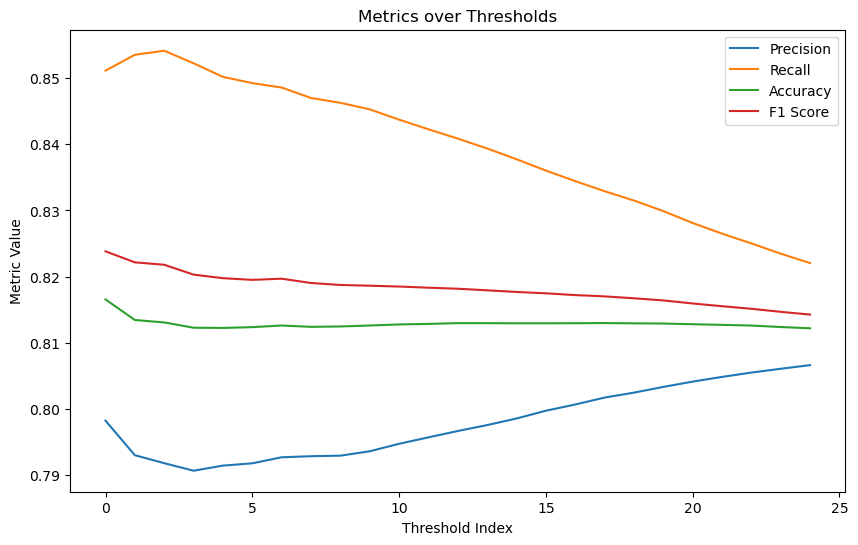

In [100]:
import matplotlib.pyplot as plt

# separate the values
precision = [thresholds[x]['precision'] for x in thresholds]
recall = [thresholds[x]['recall'] for x in thresholds]
accuracy = [thresholds[x]['accuracy'] for x in thresholds]
f1 = [thresholds[x]['f1'] for x in thresholds]

# plot the values
plt.figure(figsize=(10, 6))
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1, label='F1 Score')
plt.title('Metrics over Thresholds')
plt.xlabel('Threshold Index')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [101]:
max_acc = max_f1 = -1
best_threshold_acc=best_threshold_fi = None
for threshold in thresholds:

    if thresholds[threshold]['accuracy'] > max_acc :
        max_acc = thresholds[threshold]['accuracy']
        
        best_threshold_acc = threshold

    if thresholds[threshold]['f1'] > max_f1:
        max_f1 = thresholds[threshold]['f1']
        best_threshold_fi = threshold

print(f"Best threshold f1: {best_threshold_fi}, F1: {max_f1}")
print(f"Best threshold acc: {best_threshold_acc}, ACC: {max_acc}")

Best threshold f1: 0.34, F1: 0.8238246536030056
Best threshold acc: 0.34, ACC: 0.8165623946911372


In [102]:
# find the best threshold for the model 
thresholds = {}

precision, recall, accuracy, f1 = [], [], [], []
for _ in range(10):
    precision_, recall_, accuracy_, f1_ = evaluate_model(model, test_loader, threshold=best_threshold_acc)
    precision.append(precision_)
    recall.append(recall_)
    accuracy.append(accuracy_)
    f1.append(f1_)
print(f'Threshold: {best_threshold_acc}')
print(f'Precision: {np.mean(precision)}')
print(f'Recall: {np.mean(recall)}')
print(f'Accuracy: {np.mean(accuracy)}')
print(f'F1 Score: {np.mean(f1)}')

    


Threshold: 0.34
Precision: 0.8064751920698978
Recall: 0.8221869786864321
Accuracy: 0.8121862858517543
F1 Score: 0.8142551787495966
